In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
libpath = os.path.join(path1p, "lib")

sys.path.insert(0, libpath) 
print("Appended library directory", libpath)

# User libraries
from models.test_lib import noisePure, noiseLPF, sampleTrials
from models.dyn_sys import DynSys

from idtxl_wrapper import idtxlParallelCPU, idtxlResultsParse

Appended library directory /media/aleksejs/DataHDD/work/codes/theoretical-models/experimental-bridge/nest-mesoscopic-metric-test/codes/lib


/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
def matdiff(m1, m2):
    TP = FP = FN = TN = 0
    for i in range(m1.shape[0]):
        for j in range(m1.shape[1]):
            NAN1 = np.isnan(m1[i, j])
            NAN2 = np.isnan(m2[i, j])
            TP += (not NAN1) and (not NAN2)
            FP += (not NAN1) and (NAN2)
            FN += (NAN1) and (not NAN2)
            TN += (NAN1) and (NAN2)
            
    T1 = FP / (FP + TP) if FP + TP != 0 else 0
    T2 = FN / (FN + TN) if FN + TN != 0 else 0
    FP_RATE = FP / np.prod(m1.shape)
    FN_RATE = FN / np.prod(m1.shape)
            
    return TP,FP,FN,TN,T1,T2,FP_RATE,FN_RATE

def testplots(ndata, te_3D, lag_3D, p_3D, TRUE_CONN, logx=True):
    # Analysis
    NSTEP = te_3D.shape[2]
    test_fp = np.array([matdiff(te_3D[:, :, i], TRUE_CONN) for i in range(NSTEP)]).transpose()
    freq_conn = NSTEP - np.sum(np.isnan(te_3D), axis=2)
    
    # Plots
    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(15,10))
    ax[0][0].set_title("Error rates")
    if logx:
        #ax[0][0].semilogx(ndata, test_fp[4], label='T1')
        #ax[0][0].semilogx(ndata, test_fp[5], label='T2')
        ax[0][0].semilogx(ndata, test_fp[6], label='FP_RATE')
        ax[0][0].semilogx(ndata, test_fp[7], label='FN_RATE')
    else:
        #ax[0][0].plot(ndata, test_fp[4], label='T1')
        #ax[0][0].plot(ndata, test_fp[5], label='T2')
        ax[0][0].plot(ndata, test_fp[6], label='FP_RATE')
        ax[0][0].plot(ndata, test_fp[7], label='FN_RATE')
    ax[0][0].legend()
    
    ax[0][1].set_title("True connections")
    ax[0][1].imshow(TRUE_CONN)
    
    ax[1][1].set_title("Frequencies of connections")
    ax[1][1].imshow(freq_conn, vmin=0, vmax=NSTEP)
    
    ax[1][0].set_title("TE for each connection")
    ax[1][2].set_title("p for each connection")
    ax[0][2].set_title("lag for each connection")
    ax[0][2].set_yticks(list(range(1, int(np.nanmax(lag_3D))+1)))
    for i in range(model_param['N_NODE']):
        for j in range(model_param['N_NODE']):
            if logx:
                ax[1][0].loglog(ndata, te_3D[i, j, :], '.-')
                ax[1][2].loglog(ndata, p_3D[i, j, :], '.-')
                ax[0][2].semilogx(ndata, lag_3D[i, j, :], '.-')
            else:
                ax[1][0].semilogy(ndata, te_3D[i, j, :], '.-')
                ax[1][2].semilogy(ndata, p_3D[i, j, :], '.-')
                ax[0][2].plot(ndata, lag_3D[i, j, :], '.-')
            
    plt.show()

In [17]:
%%time
idtxl_settings = {
#     'dim_order'       : 'ps',
    'dim_order'       : 'rsp',
#     'method'          : 'BivariateTE',
    'method'          : 'MultivariateTE',
    'cmi_estimator'   : 'JidtGaussianCMI',
    'max_lag_sources' : 5,
    'min_lag_sources' : 1}

model_param = {
    'N_NODE'      : 12,             # Number of channels 
    'T_TOT'       : 100,            # seconds, Total simulation time
    'TAU_CONV'    : 0.5,            # seconds, Ca indicator decay constant
    'DT'          : 0.001,          # seconds, Neuronal spike timing resolution
    'DT_MACRO'    : 0.2,            # seconds, Binned optical recording resolution
    'STD'         : 1               # Standard deviation of random data
}

# Set parameters
# model_param = {
#     'ALPHA'   : 0.1,  # 1-connectivity strength
#     'N_NODE'  : 12,   # Number of variables
#     'N_DATA'  : 4000, # Number of timesteps
#     'MAG'     : 0,    # Magnitude of input
#     'T'       : 20,   # Period of input oscillation
#     'STD'     : 0.2   # STD of neuron noise
# }

#ttot_lst = (10 * 2**np.linspace(1, 8, 20)).astype(int)
# ttot_lst = (0.05 * 2**np.linspace(1, 8, 20))
# ttot_lst = (25 * 2**np.linspace(1, 9, 20)).astype(int)
ttot_lst = 100*np.linspace(1, 10, 10).astype(int)

NSTEP = len(ttot_lst)
ndata = np.zeros(NSTEP)
te_3D = np.zeros((model_param['N_NODE'], model_param['N_NODE'], NSTEP))
lag_3D = np.zeros((model_param['N_NODE'], model_param['N_NODE'], NSTEP))
p_3D = np.zeros((model_param['N_NODE'], model_param['N_NODE'], NSTEP))

for i, ttot in enumerate(ttot_lst):
    
#     model_param['T_TOT'] = ttot
#     model_param['N_DATA'] = ttot
    
#     data = noisePure(model_param)
    data = noiseLPF(model_param)
#     DS1 = DynSys(model_param)
#     data = np.copy(DS1.data)
    data = sampleTrials(data, ttot, idtxl_settings['max_lag_sources']+1)

#     ndata[i] = data.shape[1]
    ndata[i] = data.shape[0]
    rez = idtxlParallelCPU(data, idtxl_settings)
    
    TE, lag, p = idtxlResultsParse(rez, model_param['N_NODE'], method=idtxl_settings['method'], storage='matrix')
    te_3D[:,:,i] = TE
    lag_3D[:,:,i] = lag
    p_3D[:,:,i] = p

Adding data with properties: 12 processes, 6 samples, 100 replications
overwriting existing data
Adding data with properties: 12 processes, 6 samples, 200 replications
overwriting existing data
Adding data with properties: 12 processes, 6 samples, 300 replications
overwriting existing data
Adding data with properties: 12 processes, 6 samples, 400 replications
overwriting existing data
Adding data with properties: 12 processes, 6 samples, 500 replications
overwriting existing data
Adding data with properties: 12 processes, 6 samples, 600 replications
overwriting existing data
Adding data with properties: 12 processes, 6 samples, 700 replications
overwriting existing data
Adding data with properties: 12 processes, 6 samples, 800 replications
overwriting existing data
Adding data with properties: 12 processes, 6 samples, 900 replications
overwriting existing data
Adding data with properties: 12 processes, 6 samples, 1000 replications
overwriting existing data
CPU times: user 7.54 s, sys: 

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/numpy/ma/core.py:715: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)
/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


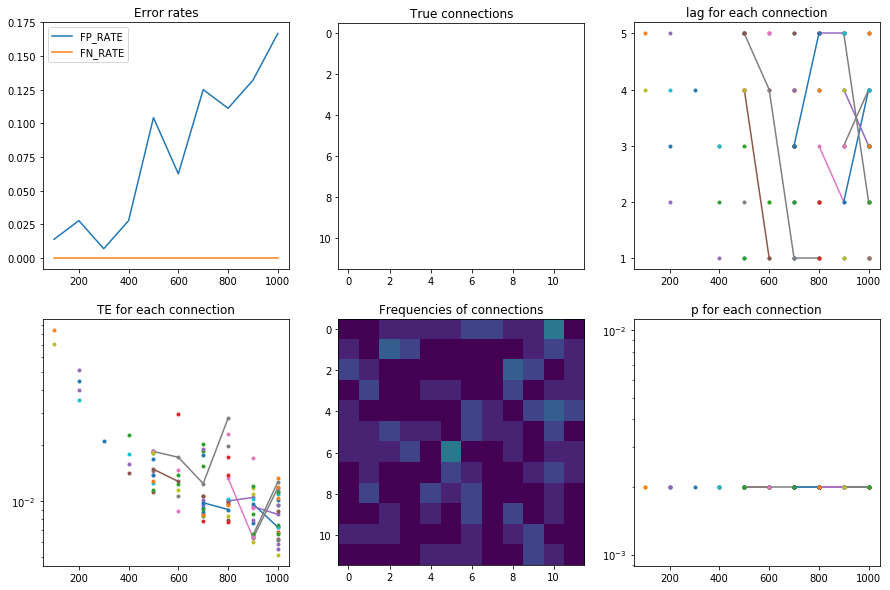

In [18]:
TRUE_CONN = np.zeros((model_param['N_NODE'], model_param['N_NODE'])) + np.nan
# TRUE_CONN = np.copy(DS1.M.transpose())
# TRUE_CONN[TRUE_CONN==0] = np.nan
# TRUE_CONN += np.diag([np.nan]*model_param['N_NODE'])
testplots(ndata, te_3D, lag_3D, p_3D, TRUE_CONN, logx=False)